In [52]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from scipy import stats

from IPython.display import display, Javascript, Markdown as md

# Import & Clean Dataset

In [53]:
df = pd.read_csv('insurance_data.csv',delimiter=';',decimal=',')

In [54]:
df.head()

,insuree#,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal
0,1,F,0.0,Yes,Yes,23,Yes,No,No,NaN,12.0,Yes,19.65,"451,55",Y
1,2,F,1.0,No,No,42,Yes,Yes,Class A,3,1.0,Yes,84.65,"3541,35",N
2,3,F,0.0,Yes,No,72,Yes,No,No,NaN,12.0,No,19.40,"1496,45",Y
3,4,F,0.0,Yes,Yes,13,Yes,No,No,NaN,12.0,No,19.55,"265,3",Y
4,5,F,0.0,No,No,37,Yes,Yes,Class A,"3,4",1.0,No,100.30,"3541,4",Y


In [55]:
#check null values
df.isnull().sum()

insuree#                       0
gender                       113
is45OrOlder                   96
isMarried                      0
hasKids                        0
insuredMonths                  0
termLifeInsurance              0
multipleTermLifePolicies       0
healthInsurance                0
healthRiders                1982
premiumFrequency             114
eStatements                    0
monthlyPremium                 0
totalPremium                   0
renewal                        0
dtype: int64

In [56]:
# Check unique values for each column
for c in df.columns:
    print(f"Unique values for column {c}")
    print(df[c].unique(),'\n')

Unique values for column insuree#
[   1    2    3 ... 5498 5499 5500] 

Unique values for column gender
['F' 'M' nan] 

Unique values for column is45OrOlder
['0.0' '1.0' nan] 

Unique values for column isMarried
['Yes' 'No'] 

Unique values for column hasKids
['Yes' 'No'] 

Unique values for column insuredMonths
[ 23  42  72  13  37   3  24  31   1  57   6   7  65  40  18  15   2   4
  69   0  59  16  66  27  29  11  61  39  41  62  70  56  30  22  71  54
  20  26  55  51   5  58  32 170  12  67  14  43  33  60  25   9  45  21
  19  36  44  34   8  53  52  46  17  50  63  10  35  68  38  49  64  48
 130 410  47  28 670 720 610 180 550 160 430 340 710 520 230 690 220 420
 460 700 240 620  80 600 320 260 470] 

Unique values for column termLifeInsurance
['Yes' 'No'] 

Unique values for column multipleTermLifePolicies
['No' 'Yes' 'no term life policy taken' 'term life policy not taken'] 

Unique values for column healthInsurance
['No' 'Class A' 'Class B'] 

Unique values for column health

## Data cleaning

In [57]:
# make copy of dataframe
clean_df = df.copy()

In [58]:
#Ensure insuree id is unique
print("num of rows:",len(clean_df),", unique insuree#:",clean_df['insuree#'].nunique())

num of rows: 5500 , unique insuree#: 5500


In [59]:
# Remap free text values to No
free_text_life_policies = {'no term life policy taken','term life policy not taken'}
clean_df['multipleTermLifePolicies'] = clean_df['multipleTermLifePolicies'].apply(lambda x: 'No' if x in free_text_life_policies else x)

clean_df['multipleTermLifePolicies'].unique()

array(['No', 'Yes'], dtype=object)

In [60]:
#Convert comma to decimal for dollar figure columns
def clean_totalPremium(x):
    if x == np.nan or len(x.strip()) == 0:
        return np.nan
    else:
        return float(x.replace(',', '.'))

clean_df['totalPremium'] = clean_df['totalPremium'].apply(clean_totalPremium)

In [61]:
#map binary columns as category to preserve NaNs
free_text_yesno_map = {'Yes':True,'No':False,np.nan:np.nan}
bool_map = {
    'is45OrOlder':{'1.0':True,'0.0':False,np.nan:np.nan},
    'isMarried':free_text_yesno_map,
    'hasKids':free_text_yesno_map,
    'termLifeInsurance':free_text_yesno_map,
    'multipleTermLifePolicies':free_text_yesno_map,
    'eStatements':free_text_yesno_map,
    'renewal':{'Y':True,'N':False,np.nan:np.nan}
}

for col,d in bool_map.items():
    clean_df[col] = clean_df[col].map(d).astype('category')

In [62]:
#convert categorical columns
clean_df['gender'] = clean_df['gender'].astype('category')
clean_df['healthInsurance'] = clean_df['healthInsurance'].astype('category')

In [63]:
#convert healthrider column to tuple 
import ast
def convert_to_tuple(x):
    if pd.isnull(x):
        return ()
    else:
        x = ast.literal_eval(x)
    if isinstance(x,tuple):
        return x
    else:
        return (x,)
clean_df['healthRiders'] = clean_df['healthRiders'].apply(convert_to_tuple)
clean_df['numHealthRiders'] = clean_df['healthRiders'].str.len()

In [64]:
#create boolean columns for each of the 4 riders

max_healthRiders = 4 #inferred from unique values

new_healthRiders_columns = [f"healthRider_{i}" for i in range(1,max_healthRiders+1)]

def expand_healthRiders_list(x):
    riders = x['healthRiders']
    result = []
    
    for i in range(1,max_healthRiders+1):
        result.append(i in riders)
    return result

clean_df[new_healthRiders_columns] = clean_df.apply(expand_healthRiders_list, result_type='expand',axis=1)

In [65]:
#create copy of clean df with null/empty values filtered out

def c(x):
    if isinstance(x,str):
        return x.strip() == ''
    else:
        return False
string_empty_mask = df.applymap(c).any(axis=1)
nn_mask = df.isnull().any(axis=1)
nn_and_empty_mask = ~string_empty_mask & ~nn_mask
clean_df_nn = clean_df[nn_and_empty_mask].copy()

#for copy of cleaned data without null values, set dtype to boolean as no nans need to be preserved
for col,d in bool_map.items():
    clean_df_nn[col] = clean_df_nn[col].astype(bool)

In [66]:
print(clean_df.info())
clean_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   insuree#                  5500 non-null   int64   
 1   gender                    5387 non-null   category
 2   is45OrOlder               5404 non-null   category
 3   isMarried                 5500 non-null   category
 4   hasKids                   5500 non-null   category
 5   insuredMonths             5500 non-null   int64   
 6   termLifeInsurance         5500 non-null   category
 7   multipleTermLifePolicies  5500 non-null   category
 8   healthInsurance           5500 non-null   category
 9   healthRiders              5500 non-null   object  
 10  premiumFrequency          5386 non-null   float64 
 11  eStatements               5500 non-null   category
 12  monthlyPremium            5500 non-null   float64 
 13  totalPremium              5491 non-null   float6

,insuree#,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal,numHealthRiders,healthRider_1,healthRider_2,healthRider_3,healthRider_4
0,1,F,False,True,True,23,True,False,No,(),12.0,True,19.65,451.55,True,0,False,False,False,False
1,2,F,True,False,False,42,True,True,Class A,"(3,)",1.0,True,84.65,3541.35,False,1,False,False,True,False
2,3,F,False,True,False,72,True,False,No,(),12.0,False,19.40,1496.45,True,0,False,False,False,False
3,4,F,False,True,True,13,True,False,No,(),12.0,False,19.55,265.30,True,0,False,False,False,False
4,5,F,False,False,False,37,True,True,Class A,"(3, 4)",1.0,False,100.30,3541.40,True,2,False,False,True,True


In [67]:
TARGET_COL = 'renewal'
CATEGORICAL_COLS = clean_df.select_dtypes(include=['bool','category']).columns.drop('renewal').to_list()
NUM_COLS = clean_df.select_dtypes(include=['float64','int64']).columns.drop('insuree#').to_list()

# EDA

### (Utility functions)

In [68]:
def create_subplots(n,figsize=(15, 25)):
    if n == 2:
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        axes_idx = [0,1]
    elif n%2 == 0:
        fig, axes = plt.subplots(n//2, 2, figsize=figsize)
        axes_idx = [[i,j] for i in range(n//2) for j in range(2)]
    
    else:
        fig, axes = plt.subplots(n//2+1, 2, figsize=figsize)
        i,j = (n-1)//2, 1
        fig.delaxes(axes[i,j])

        axes_idx = [[i,j] for i in range(n//2+1) for j in range(2)]   
    
    return fig, axes, axes_idx

def annotate_bar(ax,value_to_str=lambda x:x):
    for p in ax.patches:
        ax.annotate(value_to_str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


### Dataset Summary Statistics

In [69]:
clean_df.describe(include='all')

,insuree#,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal,numHealthRiders,healthRider_1,healthRider_2,healthRider_3,healthRider_4
count,5500.000000,5387,5404,5500,5500,5500.000000,5500,5500,5500,5500,5386.000000,5500,5500.000000,5491.000000,5500,5500.000000,5500,5500,5500,5500
unique,NaN,2,2,2,2,NaN,2,2,3,16,NaN,2,NaN,NaN,2,NaN,2,2,2,2
top,NaN,M,False,False,False,NaN,True,False,Class A,(),NaN,True,NaN,NaN,True,NaN,False,False,False,False
freq,NaN,2719,4525,2843,3857,NaN,4969,3185,2419,1982,NaN,3225,NaN,NaN,4023,NaN,3936,3612,3401,3399
mean,2750.500000,NaN,NaN,NaN,NaN,34.678909,NaN,NaN,NaN,NaN,4.086892,NaN,100.060591,3834.014924,NaN,1.391273,NaN,NaN,NaN,NaN
std,1587.857571,NaN,NaN,NaN,NaN,42.225326,NaN,NaN,NaN,NaN,4.548742,NaN,524.245115,28125.146400,NaN,1.304376,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,1.000000,NaN,18.250000,18.800000,NaN,0.000000,NaN,NaN,NaN,NaN
25%,1375.750000,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,1.000000,NaN,35.337500,403.775000,NaN,0.000000,NaN,NaN,NaN,NaN
50%,2750.500000,NaN,NaN,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,1.000000,NaN,70.350000,1400.300000,NaN,1.000000,NaN,NaN,NaN,NaN
75%,4125.250000,NaN,NaN,NaN,NaN,56.000000,NaN,NaN,NaN,NaN,3.000000,NaN,90.100000,3831.850000,NaN,2.000000,NaN,NaN,NaN,NaN


### Target Class Proportion

# Renewal Target Class Proporton
* There is a significant imbalance of the target class 'Renewal' in the dataset
* This would impact classification metrics like accuracy - F1 score will be used instead in preference


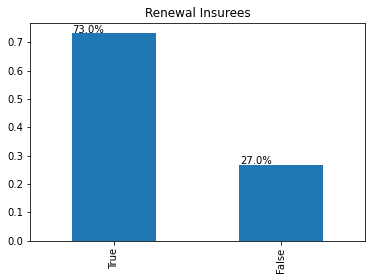

In [70]:
ax = clean_df['renewal'].value_counts(normalize=True).plot(kind='bar',title='Renewal Insurees')

display(md("""# Renewal Target Class Proporton
* There is a significant imbalance of the target class 'Renewal' in the dataset
* This would impact classification metrics like accuracy - F1 score will be used instead in preference
"""))
annotate_bar(ax,lambda x: str(round(x,2)*100)+"%")

### Data Cross Section

### Numerical variable distribution
* Spread is large - outliers are observed for all 4 numerical variables


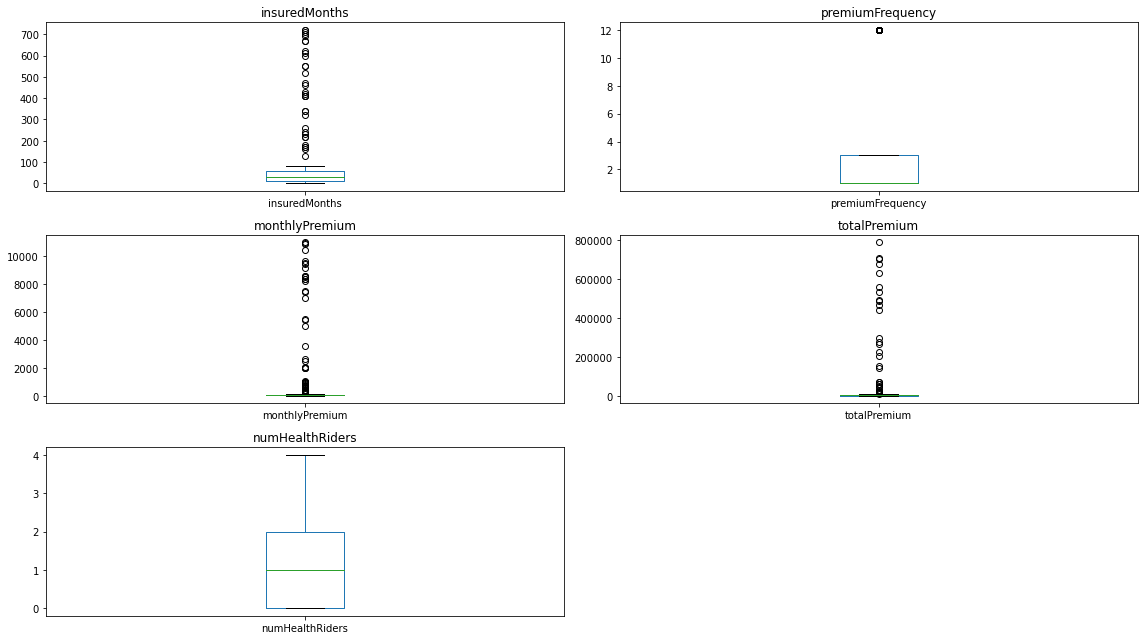

In [71]:
display(md("""### Numerical variable distribution
* Spread is large - outliers are observed for all 4 numerical variables
"""))
n = len(NUM_COLS)
fig,axes,axes_idx = create_subplots(n,figsize=(16,16))
for col,ax in list(zip(NUM_COLS,axes_idx[:n])):
    clean_df[col].plot(kind='box',figsize=(16,9),ax=axes[ax[0],ax[1]],title=col)
plt.tight_layout()

### Categorical & Binary Variable Distributions


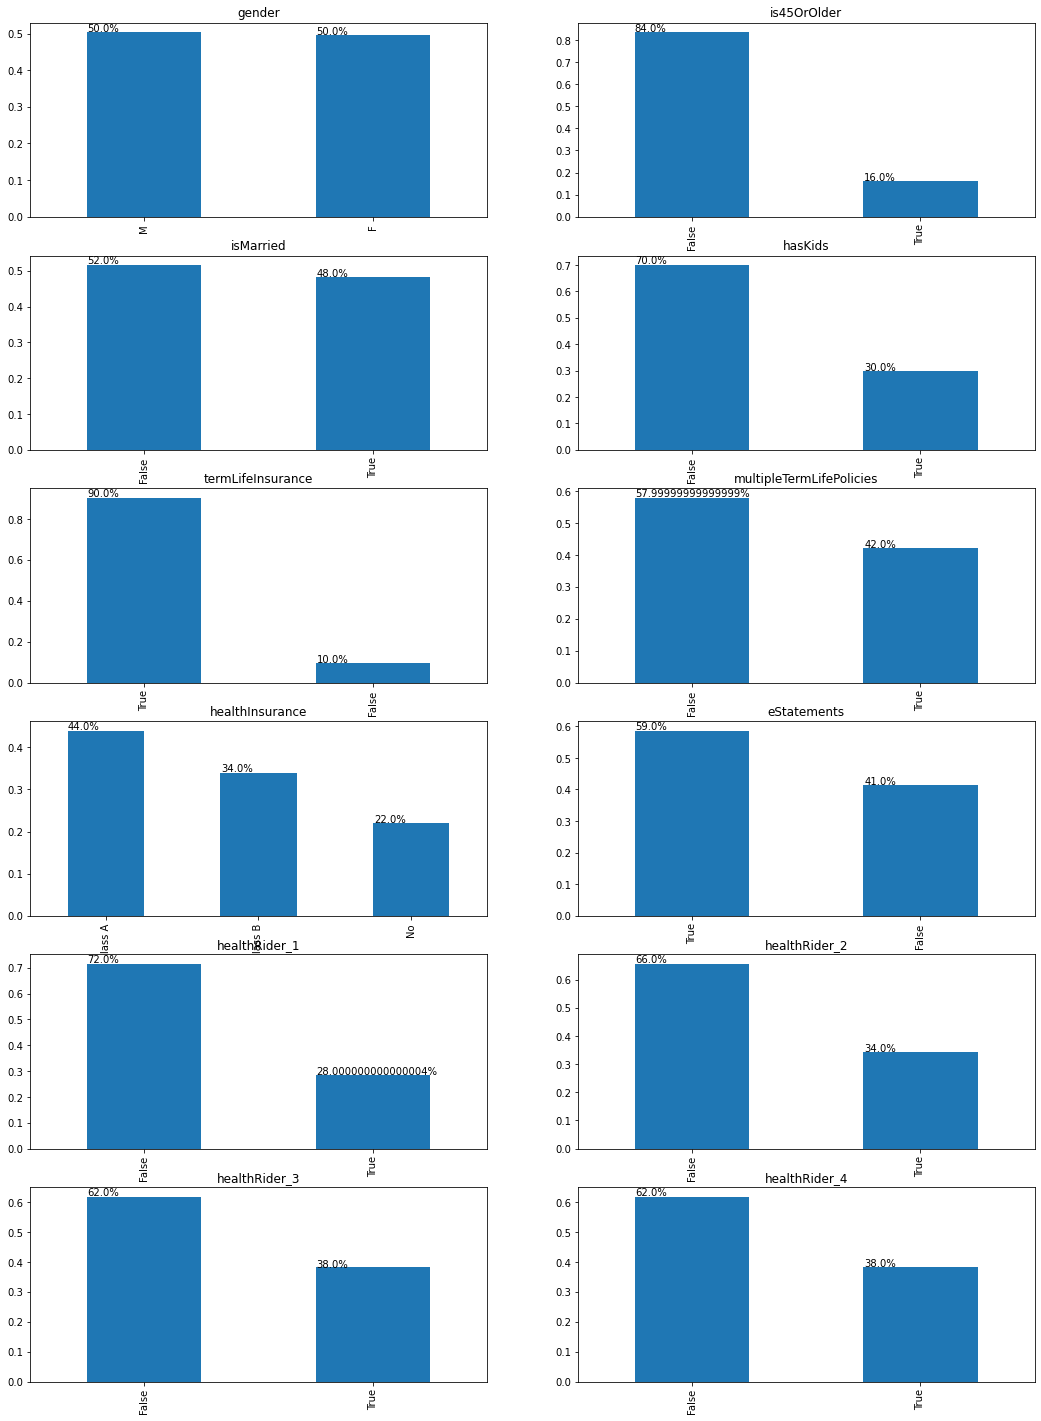

In [72]:
n = len(CATEGORICAL_COLS)
fig,axes,axes_idx = create_subplots(n,figsize=(18,25))
display(md("""### Categorical & Binary Variable Distributions
"""))
for col,ax in list(zip(CATEGORICAL_COLS,axes_idx[:n])):
    ax = clean_df[col].value_counts(normalize=True).plot(kind='bar',ax=axes[ax[0],ax[1]],title=col)
    annotate_bar(ax,lambda x: str(round(x,2)*100)+"%")

<ipython-input-73-7f73fe47df56>:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_hrs.append(len(elderly_only[clean_df[col] == True]))
<ipython-input-73-7f73fe47df56>:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_hrs.append(len(elderly_only[clean_df[col] == True]))
<ipython-input-73-7f73fe47df56>:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_hrs.append(len(elderly_only[clean_df[col] == True]))
<ipython-input-73-7f73fe47df56>:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_hrs.append(len(elderly_only[clean_df[col] == True]))



### Health Riders Analysis
* Average number of Health Riders: **1.39**
* Most popular Health Rider: **healthRider_4**
* Most popular Health Rider among older insurees (age>= 45): **healthRider_4**


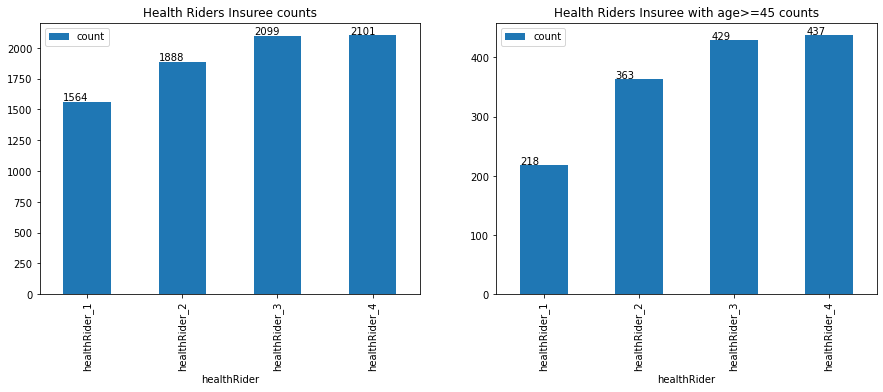

In [73]:
avg_hr = round(clean_df['numHealthRiders'].mean(),2)

healthRiders_columns = [f"healthRider_{i}" for i in range(1,max_healthRiders+1)]


#overall rider counts
num_hrs = []
for col in healthRiders_columns:
    num_hrs.append(len(clean_df[clean_df[col] == True]))

healthrider_count_df = pd.DataFrame(list(zip(healthRiders_columns,num_hrs)),columns=['healthRider','count'])
mode_healthrider = healthrider_count_df.query(f"count == {healthrider_count_df['count'].max()}")['healthRider'].iloc[0]

fig,axes,axes_idx = create_subplots(2,figsize=(15,5))

ax = healthrider_count_df.plot(kind='bar',x='healthRider',y='count',ax=axes[0],title='Health Riders Insuree counts')
annotate_bar(ax)

#elderly rider counts
num_hrs = []
elderly_only = clean_df[clean_df['is45OrOlder'] == True]
for col in healthRiders_columns:
    num_hrs.append(len(elderly_only[clean_df[col] == True]))
elderly_healthrider_count_df = pd.DataFrame(list(zip(healthRiders_columns,num_hrs)),columns=['healthRider','count'])
mode_elderly_healthrider = elderly_healthrider_count_df.query(f"count == {elderly_healthrider_count_df['count'].max()}")['healthRider'].iloc[0]

ax = elderly_healthrider_count_df.plot(kind='bar',x='healthRider',y='count',ax=axes[1],title='Health Riders Insuree with age>=45 counts')
annotate_bar(ax)

display(md(f"""
### Health Riders Analysis
* Average number of Health Riders: **{avg_hr}**
* Most popular Health Rider: **{mode_healthrider}**
* Most popular Health Rider among older insurees (age>= 45): **{mode_elderly_healthrider}**
"""))


### Variable Relationship to Renewal Status


### Observations
* There is no significant difference between Males and Females in Renewal Rate
* Individuals age < 45 contribute to most of the renewing insurees
* Married individuals contribute to most of the renewing insurees
* Individuals with kids contribute to most of the renewing insurees
* Majority of individuals with a term life insurance are renewing their plans, and contribute to most of the renewing insurees
* Individuals with multiple term policies contribute to most of the renewing insurees
* Among renewing insurees, most have Class B health insurance
* Individuals with E Statements contribute to most of the renewing insurees
    

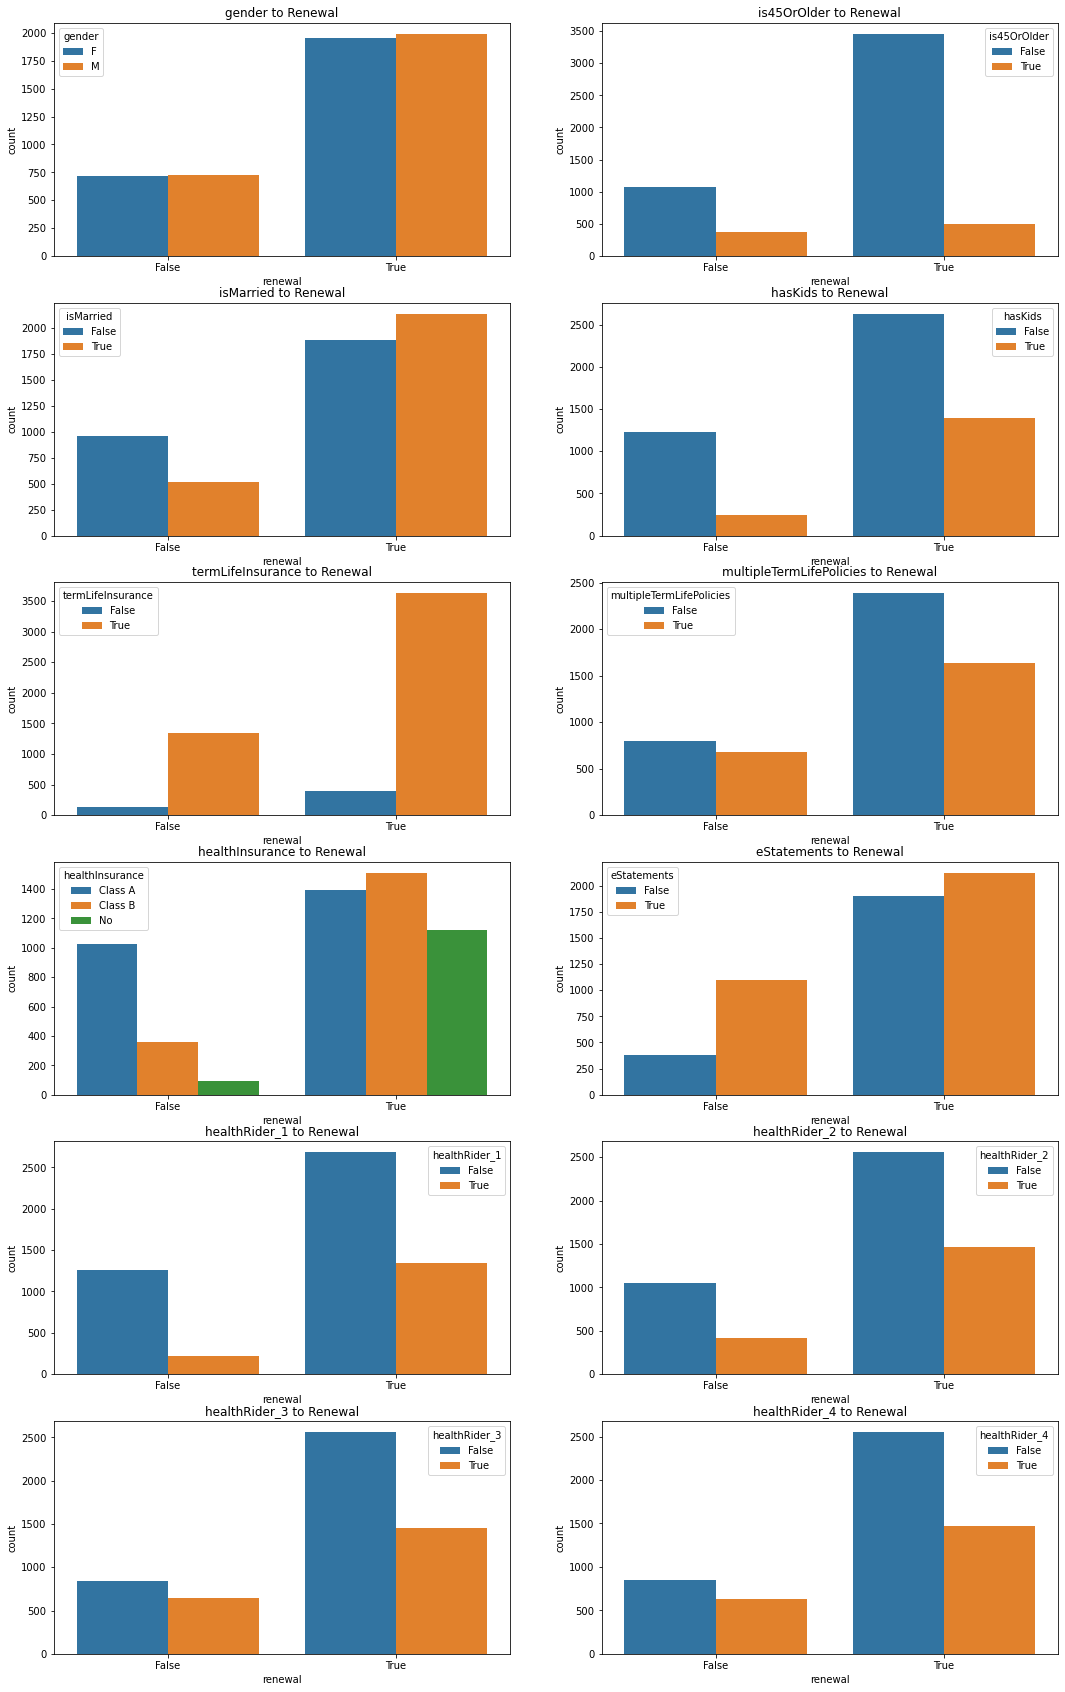

In [74]:
fig,axes,axes_idx = create_subplots(n,figsize=(18,30))
for col,ax in list(zip(CATEGORICAL_COLS,axes_idx[:n])):
    x1,x2 = clean_df['renewal'],clean_df[col]
    sns.countplot(x=x1,hue=x2,ax=axes[ax[0],ax[1]]).set_title(f'{col} to Renewal')

## Mardown display

mdout = md(
    f"""
### Observations
* There is no significant difference between Males and Females in Renewal Rate
* Individuals age < 45 contribute to most of the renewing insurees
* Married individuals contribute to most of the renewing insurees
* Individuals with kids contribute to most of the renewing insurees
* Majority of individuals with a term life insurance are renewing their plans, and contribute to most of the renewing insurees
* Individuals with multiple term policies contribute to most of the renewing insurees
* Among renewing insurees, most have Class B health insurance
* Individuals with E Statements contribute to most of the renewing insurees
    """
)

display(mdout)

### Pairplot visualisation of correlations between numerical variables
*Observations*
* There is little intercorrelation observed between the numerical independent variables
* Pairwise against renewal status - there is no significant linear separability observed


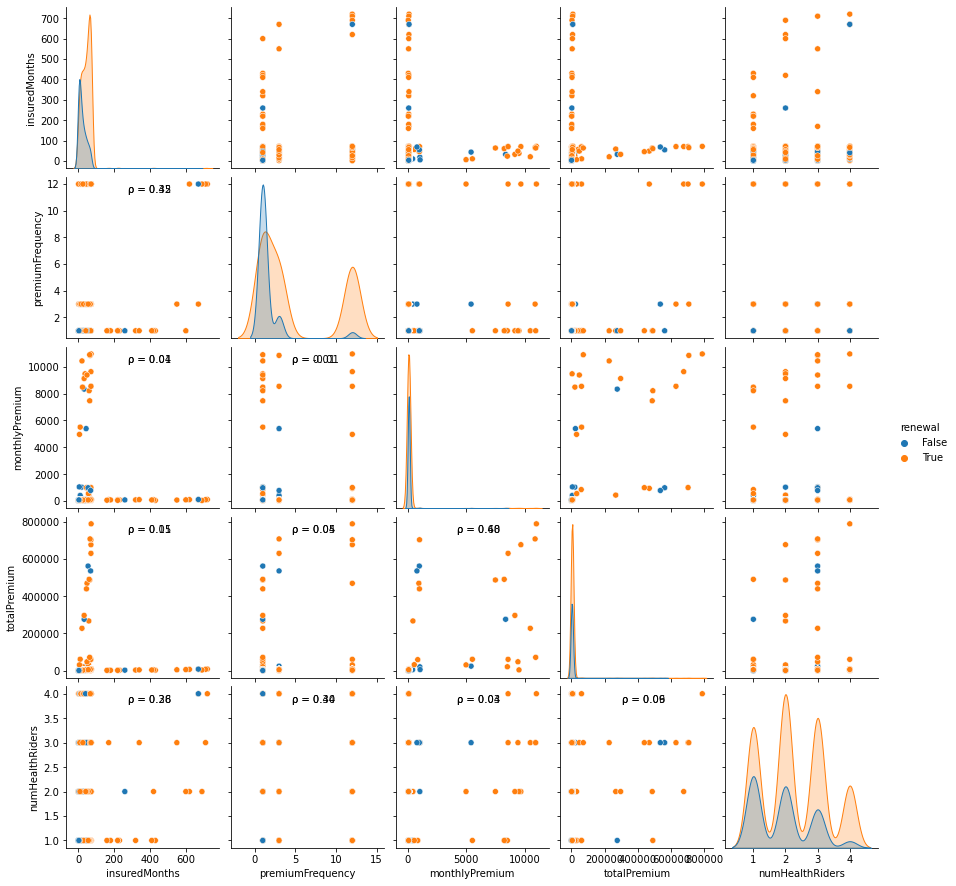

In [75]:
def calc_pcorr(x, y, ax=None, **kws):
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.4, .9), xycoords=ax.transAxes)

num_cols = ['insuredMonths','premiumFrequency','numHealthRiders','monthlyPremium','totalPremium','renewal'] 
plot = sns.pairplot(clean_df_nn[NUM_COLS+[TARGET_COL]],hue='renewal')
plot.map_lower(calc_pcorr)

display(md(f"""### Pairplot visualisation of correlations between numerical variables
*Observations*
* There is little intercorrelation observed between the numerical independent variables
* Pairwise against renewal status - there is no significant linear separability observed
"""))

# Feature Engineering & Selection

In [76]:
# Null or Empty variables are dropped for feature selection

# Bin columns created in previous IV calculation are also reused as potential features
df = clean_df_nn.copy()

### Categorical Features

In [77]:
#Label encoding
from sklearn import preprocessing

les = {}
for col in df.select_dtypes(include=['category','bool']).columns.to_list():
    les[col] = preprocessing.LabelEncoder()
    df[col] = les[col].fit_transform(df[col])

df.head()

,insuree#,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal,numHealthRiders,healthRider_1,healthRider_2,healthRider_3,healthRider_4
1,2,0,1,0,0,42,1,1,0,"(3,)",1.0,1,84.65,3541.35,0,1,0,0,1,0
4,5,0,0,0,0,37,1,1,0,"(3, 4)",1.0,0,100.30,3541.40,1,2,0,0,1,1
5,6,1,1,0,0,3,1,1,0,"(2,)",1.0,1,81.35,233.70,0,1,0,1,0,0
7,8,1,0,0,0,24,1,0,0,"(2,)",1.0,1,85.95,2107.15,1,1,0,1,0,0
8,9,0,0,0,0,24,1,0,1,"(1,)",1.0,0,56.35,1381.20,1,1,1,0,0,0


### Numerical Features

In [78]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#Filter out outliers
df = df[(np.abs(stats.zscore(df[NUM_COLS],axis=0)) < 3).all(axis=1)]

#Z score scaling
scaler = StandardScaler() 
scaler.fit(df[NUM_COLS])
df[NUM_COLS] = scaler.transform(df[NUM_COLS])
df

,insuree#,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal,numHealthRiders,healthRider_1,healthRider_2,healthRider_3,healthRider_4
1,2,0,1,0,0,0.194596,1,1,0,"(3,)",-0.674336,1,0.080702,0.139702,0,-1.198596,0,0,1,0
4,5,0,0,0,0,-0.013358,1,1,0,"(3, 4)",-0.674336,0,0.516622,0.139721,1,-0.174501,0,0,1,1
5,6,1,1,0,0,-1.427445,1,1,0,"(2,)",-0.674336,1,-0.011218,-1.133029,0,-1.198596,0,1,0,0
7,8,1,0,0,0,-0.554038,1,0,0,"(2,)",-0.674336,1,0.116912,-0.412156,1,-1.198596,0,1,0,0
8,9,0,0,0,0,-0.554038,1,0,1,"(1,)",-0.674336,0,-0.707576,-0.691489,1,-1.198596,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5490,5491,0,0,1,0,-0.470857,1,0,1,"(2, 3, 4)",1.799999,1,-0.229874,-0.489670,1,0.849594,0,1,1,1
5492,5493,1,0,1,1,-1.219491,1,0,1,"(1,)",-0.674336,1,-0.848241,-1.064576,1,-1.198596,1,0,0,0
5494,5495,0,0,1,1,-1.136310,1,0,1,"(2, 4)",-0.674336,1,-0.452709,-0.985580,1,-0.174501,0,1,0,1
5495,5496,0,0,1,1,-1.385854,1,1,0,"(4,)",-0.674336,1,0.116912,-1.076235,0,-1.198596,0,0,0,1


### Feature Importance

In [79]:
from sklearn.model_selection import train_test_split

# define dataset
target = 'renewal'
feature_candidates = CATEGORICAL_COLS
X, y = df[feature_candidates],df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1,stratify=y)


### Categorical Feature Importance
* Feature Importance is measured using Mutual Information metric
* Presence of health rider 1, and presence of kids the top 2 most significant features


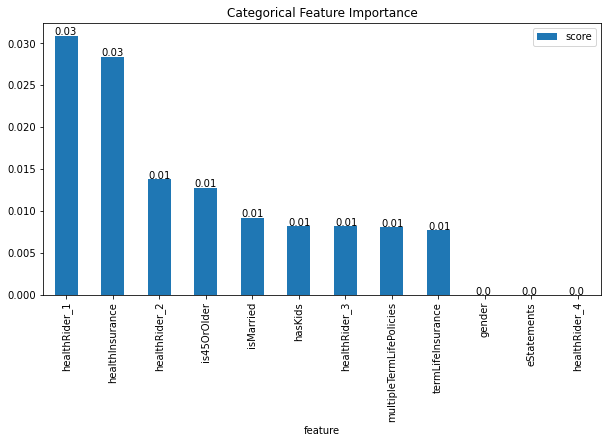

In [80]:
# Categorical Feature Importance
from sklearn.datasets import make_classification

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

#feature selection using MI
fs = SelectKBest(score_func=mutual_info_classif, k='all')
fs.fit(X_train, y_train)

importance = fs.scores_

feat_importance_df = pd.DataFrame(data=list(zip(feature_candidates,importance)),columns=['feature','score'])
feat_importance_df = feat_importance_df.sort_values(by='score',ascending=False)
# display(feat_importance_df)

display(md("""### Categorical Feature Importance
* Feature Importance is measured using Mutual Information metric
* Presence of health rider 1, and presence of kids the top 2 most significant features
"""))

# plot feature importance
ax = feat_importance_df.plot(kind='bar',x='feature',y='score',title='Categorical Feature Importance',figsize=(10,5))
plt.xticks(rotation=90)
annotate_bar(ax,lambda x: round(x,2))


### Numerical Feature Importance
* Against other variables, insuredMonths have the best Information Value (IV) in determining Renewal status, making it a good feature candidate
* insuredMonths and totalPremium are observed to have a decreasing linear trend in Weight of evidence


,feature,IV
0,insuredMonths,0.886552
0,totalPremium,0.561032
0,monthlyPremium,0.219538
0,numHealthRiders,0.203327


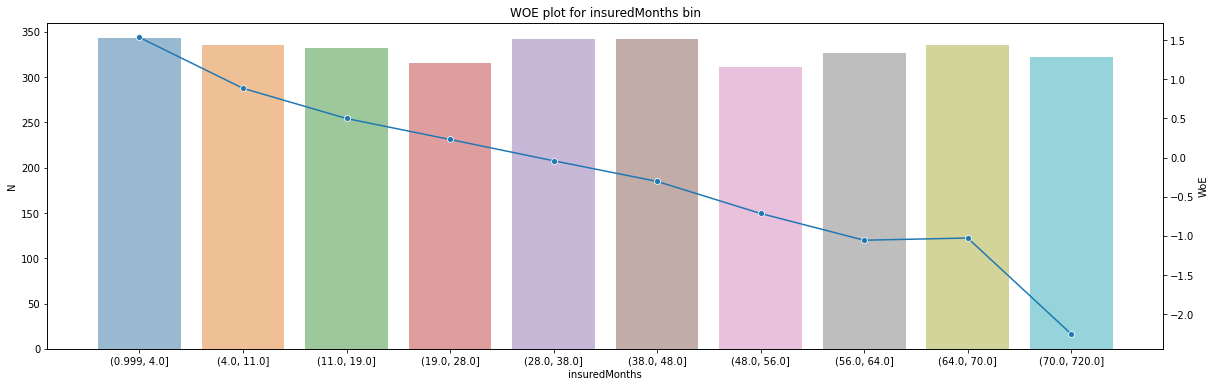

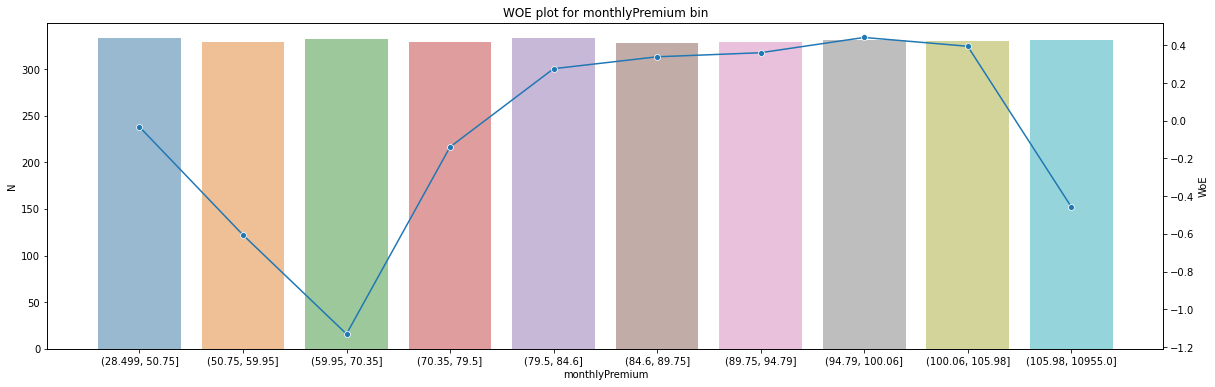

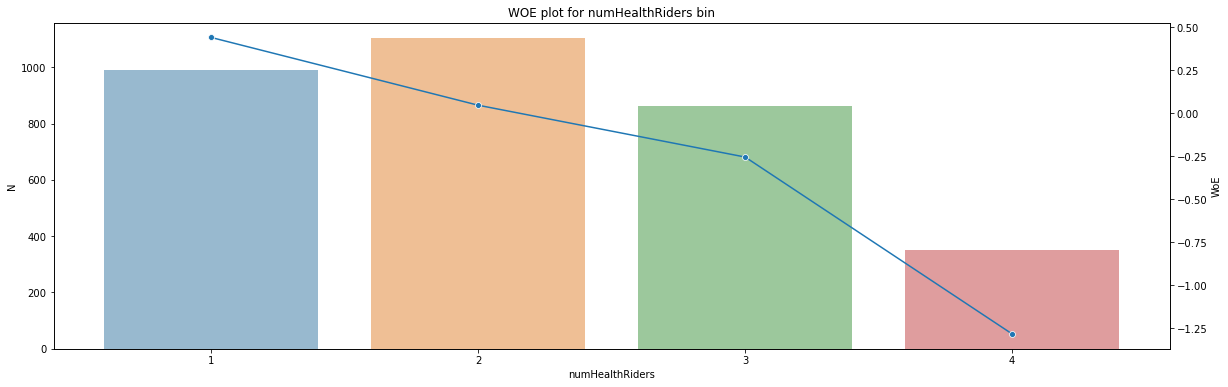

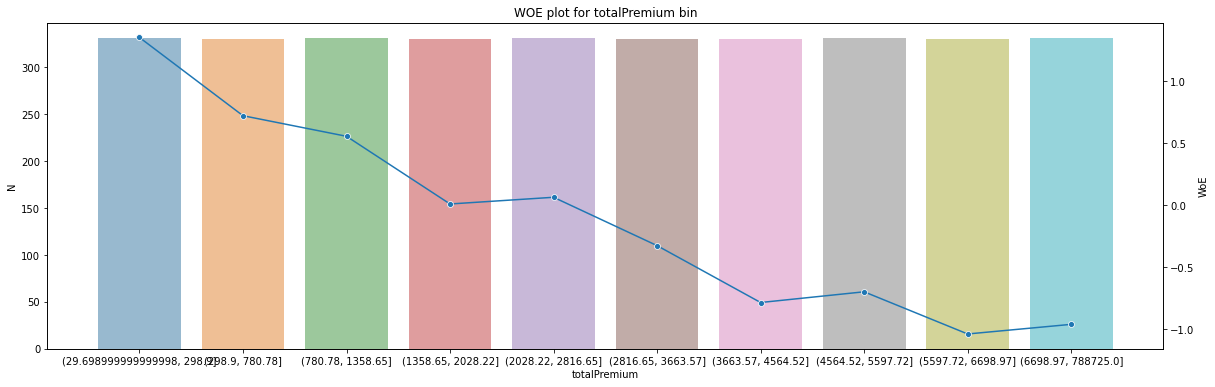

In [81]:
# Numerical Variables - Information Value and Weight of Evidence against Renewal Status
def iv_woe(data, target, bins=10, show_woe=False):
    data = data.copy()
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        #for numeric/float columns use pd.qcut to bin
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            col_name = ivars + '_bin'
            data[col_name] = binned_x
            #save the qcut bins and the 'BAD' column in d0
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
#             print(d0)
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
#             print(d0)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events'] - d['% of Events'])
        d.insert(loc=0, column='feature', value=ivars)
#         print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"feature" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["feature", "IV"])
        #find the IV for each variable and add it to the newDF in each iteration. This is the IV df
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
            
    return newDF, woeDF, data

def plot_woe(iv_df,variable):
    #filter
    iv_df = iv_df.query(f"feature == '{variable}'")
    fig, ax1 = plt.subplots(figsize=(20,6))
    sns.barplot(x = iv_df['Cutoff'] , y = iv_df['N'], alpha=0.5, ax = ax1).set_xlabel(variable)

    ax2 = ax1.twinx()
    sns.lineplot(data = iv_df['WoE'], marker='o', sort = False, ax=ax2)
    plt.title(f"WOE plot for {variable} bin")

iv_cols = ['insuredMonths','monthlyPremium','numHealthRiders','totalPremium','renewal'] #insuredMonths excluded due to limited range (2)
data = clean_df_nn[iv_cols] #calculate IV on unscaled values
iv_df,woe_df,df_binned = iv_woe(data,'renewal')

# clean_df_nn.insuredMonths_bin = clean_df_nn.insuredMonths_bin.astype('str')
# clean_df_nn.monthlyPremium_bin = clean_df_nn.monthlyPremium_bin.astype('str')
# clean_df_nn.totalPremium_bin = clean_df_nn.totalPremium_bin.astype('str')

display(md(f"""### Numerical Feature Importance
* Against other variables, insuredMonths have the best Information Value (IV) in determining Renewal status, making it a good feature candidate
* insuredMonths and totalPremium are observed to have a decreasing linear trend in Weight of evidence
"""))

iv_sorted = iv_df.sort_values(by='IV',ascending=False)
display(iv_sorted)

for col in iv_cols[:-1]:
    plot_woe(woe_df,col)

# Model

In [82]:
selected_features = feat_importance_df['feature'].iloc[:3].to_list() + iv_sorted['feature'].iloc[:3].to_list()
selected_features

['healthRider_1',
 'healthInsurance',
 'healthRider_2',
 'insuredMonths',
 'totalPremium',
 'monthlyPremium']

In [83]:
#Utility functions
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt

def plot_roc(y_test, y_probs, name):
    # calculate roc curves
    auc = round(roc_auc_score(y_test.to_list(), y_probs),3)

    ns=[0 for _ in range(len(y_test))]
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=name)
    plt.title(f"ROC AUC Curve: {name} (AUC Score = {auc})")
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

### Linear Model - Logistic Regression
* This model assumes linear separability with the features
* This will be a baseline classifier to determine if linear model is sufficient for the task

In [84]:
from sklearn.linear_model import LogisticRegression
# define the model
model = LogisticRegression()
# fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:,1]

display(md("""### Logistic Regression Model Performance
"""))
print(classification_report(y_test,y_pred))

### Logistic Regression Model Performance


              precision    recall  f1-score   support

           0       0.55      0.36      0.44       310
           1       0.77      0.88      0.82       767

    accuracy                           0.73      1077
   macro avg       0.66      0.62      0.63      1077
weighted avg       0.71      0.73      0.71      1077



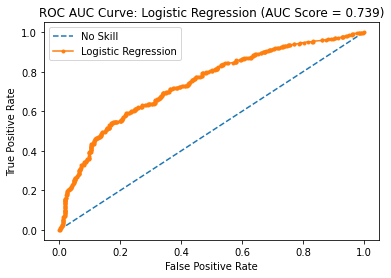

In [85]:
plot_roc(y_test,y_probs,"Logistic Regression")

### Support Vector Machine
* SVM is assessed to determine if a non linear model would have superior performance over the linear logistic regression model
* In this section a SVM will be fitted. Grid search is performed to find the best set of hyperparameters for the dataset

In [86]:
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01],'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)
print("Best Parameters")
print(grid.best_estimator_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, k

In [87]:
y_pred = grid.predict(X_test)
display(md("""### SVM Performance
"""))
print(classification_report(y_test,y_pred))

### SVM Performance


              precision    recall  f1-score   support

           0       0.55      0.28      0.38       310
           1       0.76      0.91      0.83       767

    accuracy                           0.73      1077
   macro avg       0.66      0.60      0.60      1077
weighted avg       0.70      0.73      0.70      1077



# Conclusion

* Based on the previous analysis, demographic attributes like gender and married status does not indicate likeliness of renewal
* Certain behavioural attributes like presence of kids and elderly status shown pattern in determing non-renewal status. However, those variables are highly disproportionate in the original dataset hence cannot be reliably used as indicators.
* Certain seemingly unrelated variables like presence of eStatements have shown some patterns in indicating whether a particular insuree would renew
* Using Mutual Information and Information value metrics, features with most significant importance in determining renewal status are filtered and used for modelling 
* Both Models have very similar performance, with the Logistic Regression Model performing slightly better than detecting negative non-renewing insurees
* This suggests that a linear model would suffice with the selected model, hence the Logistic Regression would be the recommended model for predicting insuree renewals.